In [1]:
using DifferentialEquations
using LaTeXStrings
using JLD2
using Printf
using PyPlot
using RandomNumbers.Xorshifts
include("HenryLib.jl")

make_white_noise (generic function with 1 method)

In [6]:
seed = Int(round(mod(time()*300,1000)))

218

In [3]:
# observable indeces
a = 1
Sx = 2
Sy = 3
Sz = 4
function single_run_dicke_hetrodyne_meanfield(seed, λrel; κ=2π * 0.15, Δc=2π * 20, ωz=2π * 0.01, fockmax=4, Nspin=10000, tmax=500.0) # all in MHz or uS

    λc = 1 / 2 * sqrt((Δc^2 + κ^2) / Δc * ωz)
    λ = λrel*λc

    inital = [0im, 0., 0., -Nspin/2.]
    if λrel > 1.0
        θ_α = atan(-κ/Δc)
        Szinit = -ωz*Nspin/(8*λ^2)*sqrt(Δc^2 + κ^2)/cos(θ_α)
        Sxinit = sqrt(Nspin^2/4 - Szinit^2)
        αinit = 2im*λ/(sqrt(Nspin)*(-1im*Δc-κ))*Sxinit

        inital = [αinit, Sxinit, 0., Szinit]
    end

    
    function dicke(du, u, p, t)
        du[a] = (-1im*Δc-κ)*u[a]-2im*λ/sqrt(Nspin)*u[Sx]
        du[Sx] = -ωz*u[Sy]
        du[Sy] = ωz*u[Sx]-2*λ/sqrt(Nspin)*(u[a] + conj(u[a]))*u[Sz]
        du[Sz] = 2*λ/sqrt(Nspin)*(u[a] + conj(u[a]))*u[Sy]
    end

    function σ_dicke(du, u, p, t)
        du[a] = sqrt(κ/2)
        du[Sx] = 0.
        du[Sy] = 0.
        du[Sz] = 0.
    end

    rng = Xoroshiro128Plus(seed)
    W = WienerProcess(0.0, im * 0.0, im * 0.0, rng=rng)

    # can_dual(::Type{ComplexF64}) = true

    prob_dicke = SDEProblem{true}(dicke, σ_dicke, inital, (0.0, tmax), noise=W, dt=1/(5*Δc))
    sol = solve(prob_dicke, SOSRI2(), maxiters=10^8, saveat=0.01)
    return sol, W
end

single_run_dicke_hetrodyne_meanfield (generic function with 1 method)

In [8]:
seed = 24
λrel = 1.1
sol, W = single_run_dicke_hetrodyne_meanfield(seed, λrel, tmax=5.0)

(RODESolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, NoiseProcess{ComplexF64, 1, Float64, ComplexF64, ComplexF64, Vector{ComplexF64}, typeof(DiffEqNoiseProcess.WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.WHITE_NOISE_BRIDGE), false, ResettableStacks.ResettableStack{Tuple{Float64, ComplexF64, ComplexF64}, false}, ResettableStacks.ResettableStack{Tuple{Float64, ComplexF64, ComplexF64}, false}, RSWM{Float64}, Nothing, Xoroshiro128Plus}, SDEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, true, SciMLBase.NullParameters, NoiseProcess{ComplexF64, 1, Float64, ComplexF64, ComplexF64, Vector{ComplexF64}, typeof(DiffEqNoiseProcess.WHITE_NOISE_DIST), typeof(DiffEqNoiseProcess.WHITE_NOISE_BRIDGE), false, ResettableStacks.ResettableStack{Tuple{Float64, ComplexF64, ComplexF64}, false}, ResettableStacks.ResettableStack{Tuple{Float64, ComplexF64, ComplexF64}, false}, RSWM{Float64}, Nothing, Xoroshiro128Plus}, SDEFunction{true, SciMLBase.FullSpecialize, var"#d

In [2]:
function convert_to_whitenoise(Wu, Wt, time)
    white_noise = zeros(ComplexF64, length(time))
    prev_index = 1
    new_index = 1
    for i = 2:length(time)
        new_index = prev_index
        while Wt[new_index] <= time[i] && new_index < length(Wt)
            new_index += 1
        end
        white_noise[i] = (Wu[new_index] - Wu[prev_index])/(time[i] - time[i-1])
        prev_index = new_index
    end
    return white_noise
end

convert_to_whitenoise (generic function with 1 method)

In [2]:
seed = 24
λrels = LinRange(0.0, 3.0, 30)
λrel = λrels[6]

rslt = load("MeanFieldRslts/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2");
tout = rslt["t"]

LoadError: ArgumentError: No file exists at given path: MeanFieldRslts/seed=24lambda=0.517.jld2

In [3]:
# seeds = [42, 1337, 1729, 724, 333, 137, 31459, 271828, 24, 240]
seed = 24
λrels = LinRange(0.0, 3.0, 30)
a = 1
Sx = 2
Sy = 3
Sz = 4
# short_list = λrels[1:7]
cm = get_cmap(:spring)
κ=2π*0.15
for λrel in λrels[1:1]
    rslt = load("MeanFieldRslts/seed=$(seed)lambda=$(round(λrel,digits=3)).jld2");
    tout = rslt["t"]
    a = map((x)->x[1], rslt["u"])
    white_noise = convert_to_whitenoise(rslt["WArr"], tout, tout)

    Jhet = conj(white_noise)#sqrt(2*κ)*a + conj(white_noise);
    dt = tout[2] - tout[1]
    println(mean(white_noise), " ", std(white_noise), " ", 1/sqrt(dt))
    tau = dt*10
    Jhetfilt = exp_filter(Jhet, tau, dt)
    time_bins = 1000
    time = dt*collect(1:time_bins)

    Background = exp.(-time/tau)/(dt)*(1 - exp(-dt/tau))^2/(1 - exp(-2*dt/tau))

    # PyPlot.plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins))#  - Background
    # PyPlot.plot(time, Background)
    PyPlot.plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - Background, color=cm(λrel/λrels[end]), label="$(round(λrel,digits=2))")
    # plot(time, two_point_correlator(Jhetfilt, tout, dt, time_bins) - two_point_correlator(exp_filter(conj(white_noise), tau, dt), tout, dt, time_bins))
end
# legend()
xlabel(L"$\tau$ [$\mu$s]")
ylabel(L"$G^1 (\tau)$")
# PyPlot.colorbar()
PyPlot.title("Unnormalized G1 correlator, seed=$(seed)")
PyPlot.display_figs()

LoadError: ArgumentError: No file exists at given path: MeanFieldRslts/seed=24lambda=0.0.jld2

In [29]:
function lorenz!(du, u, p, t)
    du[1] = 10.0 * (u[2] - u[1])
    du[2] = u[1] * (28.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - (8 / 3) * u[3]
end

function σ_lorenz!(du, u, p, t)
    du[1] = 3.0
    du[2] = 3.0
    du[3] = 3.0
end

prob_sde_lorenz = SDEProblem(lorenz!, σ_lorenz!, [1.0, 0.0, 0.0], (0.0, 10.0))
sol = solve(prob_sde_lorenz)

retcode: Success
Interpolation: 1st order linear
t: 41425-element Vector{Float64}:
  0.0
  2.8588122172097503e-5
  3.4305746606517005e-5
  4.0738074095238946e-5
  4.7974442520051125e-5
  5.611535699796483e-5
  6.527388578561774e-5
  7.557723067172728e-5
  8.716849366860051e-5
  0.00010020866454008289
  ⋮
  9.996291272341141
  9.996808901913955
  9.997321988414516
  9.997830184594973
  9.998332565703002
  9.998833251262093
  9.999331515410034
  9.99982864588541
 10.0
u: 41425-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [1.0129472967010278, 0.011081515658243848, -0.014178210426925112]
 [1.021584142468671, 0.004920615518097799, -0.004755071426715719]
 [1.0205860775290028, 0.009422178816987828, -0.014422939021685626]
 [1.0091467919787052, 0.008511055256020488, -0.02996221732888538]
 [1.007981909185223, 0.006597843467430617, -0.029630422815245673]
 [1.005025117255747, 0.007550398866895527, -0.02205781278847069]
 [1.0101325441539244, 0.012995171028138798, -0.02733801453177869]
 [0.997

In [30]:
sol.W

t: 2-element Vector{Float64}:
  0.0
 10.0
u: 2-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [3.521028554272337, -2.045703066542202, -4.85727243206021]

In [28]:
rslt = load("MeanFieldRslts/seed=24lambda=0.0.jld2");
tout = rslt["SolArr"].t
rslt["WtArr"]

70099-element Vector{Float64}:
   0.0
   0.026180318567368313
   0.07228672704727512
   0.09267291409432026
   0.10487346357847681
   0.11503770456974302
   0.12504283699848087
   0.1356231559629287
   0.1460984826918414
   0.1547416029956155
   ⋮
 499.93681922377726
 499.94497246080965
 499.95314294591816
 499.9607216050035
 499.9680270506353
 499.97484619109065
 499.98114872312226
 499.9881948913432
 499.9952686713239

In [160]:
tout[2:end] - tout[1:end-1]

49999-element LinRange{Float64, Int64}:
 0.0100002, 0.0100002, 0.0100002, …, 0.0100002, 0.0100002, 0.0100002

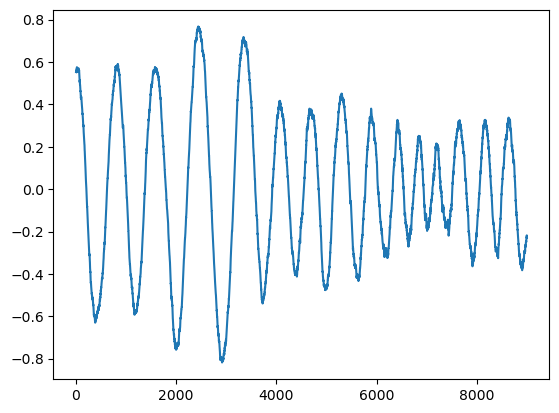

In [16]:
PyPlot.plot(real.(sol(sol.t, idxs=1).u)[1:9000])
PyPlot.display_figs()

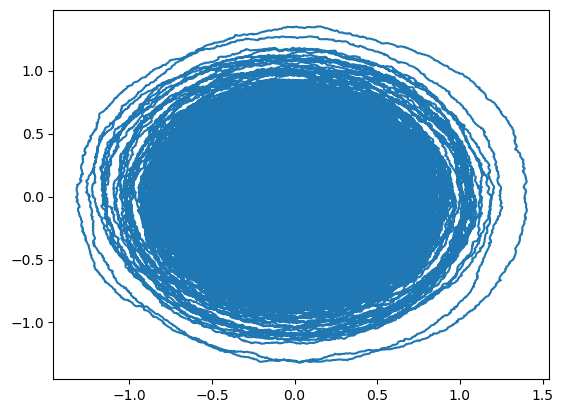

In [40]:
PyPlot.plot(real.(sol(sol.t, idxs=1).u), imag.(sol(sol.t, idxs=1).u))
PyPlot.display_figs()

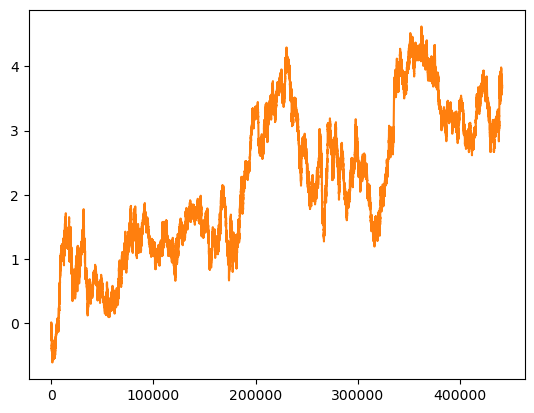

In [37]:
PyPlot.plot(W.u)
PyPlot.display_figs()

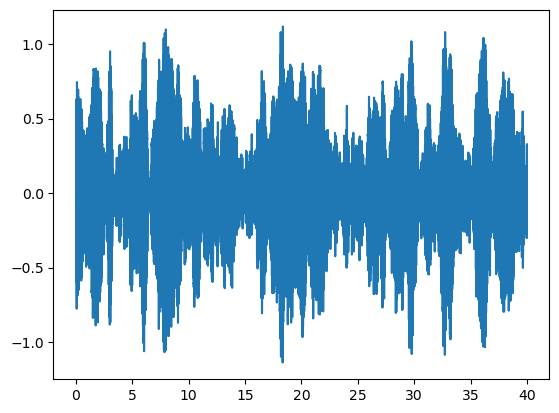

In [24]:
PyPlot.plot(sol.t, imag.(sol(sol.t, idxs=1).u))
PyPlot.display_figs()

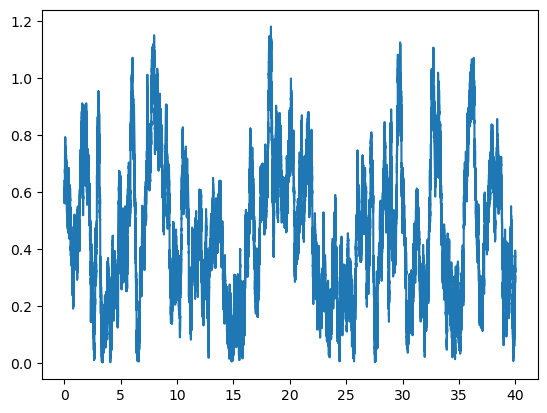

In [25]:
PyPlot.plot(sol.t, abs.(sol(sol.t, idxs=1).u))
PyPlot.display_figs()

In [14]:
plot(sol, idxs = (Sx, Sy, Sz))

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= C:\Users\henhen724\.julia\packages\PyCall\1gn3u\src\pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'AttributeError'>
AttributeError("Line2D.set() got an unexpected keyword argument 'idxs'")
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\pyplot.py", line 2812, in plot
    return gca().plot(
           ^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\axes\_base.py", line 311, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\axes\_base.py", line 544, in _plot_args
    return [l[0] for l in result]
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\axes\_base.py", line 544, in <listcomp>
    return [l[0] for l in result]
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\axes\_base.py", line 537, in <genexpr>
    result = (make_artist(x[:, j % ncx], y[:, j % ncy], kw,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\axes\_base.py", line 351, in _makeline
    seg = mlines.Line2D(x, y, **kw)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\_api\deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\lines.py", line 395, in __init__
    self._internal_update(kwargs)
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\artist.py", line 1223, in _internal_update
    return self._update_props(
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\henhen724\anaconda3\Lib\site-packages\matplotlib\artist.py", line 1197, in _update_props
    raise AttributeError(


In [15]:
twopointreal = [sum([sol[j][1]sol[j+i][1] for j=1:length(sol)-i])/(length(sol)-i) for i=1:100]

100-element Vector{Float64}:
 99.87946544184463
 99.80616438258868
 99.7502843311344
 99.74398607285129
 99.78075634163767
 99.82795855011359
 99.85410652174482
 99.84872491093178
 99.8240981294751
 99.80100066003439
 99.79332856256957
 99.80097518502149
 99.81406914230358
  ⋮
 99.81716832960416
 99.81687227580991
 99.81590345879528
 99.81536889557837
 99.81580273190109
 99.81674502594417
 99.81739797412585
 99.81756119114971
 99.81710016173845
 99.81672333437545
 99.81657444671241
 99.81655037640594

In [ ]:
twopointimag = [sum([sol[j][2]sol[j+i][2] for j=1:length(sol)-i])/(length(sol)-i) for i=1:10000]

In [89]:
# savefig("two_point_graph.png")
plot(sol.t, twopointreal, ylab=L"\langle x(0)x(t) \rangle", xlab=L"t", label=L"\langle x(0)x(t) \rangle")

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


: 

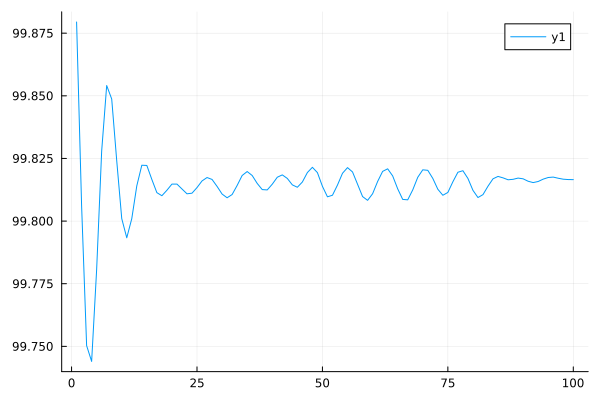

In [16]:
plot(twopointreal)

In [9]:
function save_correlators(Δ, ω, κ, g)
    # 1: (a+a^\dag)/2 
    # 2: i(a-a^\dag)/2 
    # 3: S_x 
    # 4: S_y 
    # 5: S_z
    #Δ = 1.0 # MHz
    #ω = 1.0 # MHz
    #κ = 0.01

    g_c = 1/2*sqrt(ω*(Δ^2 + κ^2)/Δ)

    if g > g_c
        inital = [g*Δ/(Δ^2 + κ^2), 0, 1.0, 0, (Δ^2 + κ^2)/Δ*ω/g^2]
    else
        inital = [0., 0., 1.0, 0., 0.]
    end

    function dicke(du, u, p, t)
        du[1] = Δ*u[2]-κ*u[1]
        du[2] = -Δ*u[1]-κ*u[2]+g*u[3]
        du[3] = -ω*u[4]
        du[4] = ω*u[3]+g*u[1]*u[5]
        du[5] = -g*u[1]*u[4]
    end

    function σ_dicke(du, u, p, t)
        du[1] = -sqrt(κ/2)
        du[2] = -sqrt(κ/2)
        du[3] = 0.
        du[4] = 0.
        du[5] = 0.
    end

    prob_sde_lorenz = SDEProblem(dicke, σ_dicke, inital, (0.0, 4000.0))
    sol = solve(prob_sde_lorenz)

    twopointxx = [sum([sol[j][1]sol[j+i][1] for j=1:length(sol)-i])/(length(sol)-i) for i=1:10000]
    twopointxy = [sum([sol[j][1]sol[j+i][2] for j=1:length(sol)-i])/(length(sol)-i) for i=1:10000]
    twopointyy = [sum([sol[j][2]sol[j+i][2] for j=1:length(sol)-i])/(length(sol)-i) for i=1:10000]
    
    JLD2.save_object("DickeRuns/d=$Δ w=$ω k=$κ g=$g xx.jld2", twopointxx)
    JLD2.save_object("DickeRuns/d=$Δ w=$ω k=$κ g=$g xy.jld2", twopointxy)
    JLD2.save_object("DickeRuns/d=$Δ w=$ω k=$κ g=$g yy.jld2", twopointyy)
end

save_correlators (generic function with 5 methods)

In [10]:
save_correlators(1.0, 1.0, 0.01, 0.01)

In [8]:
twopoint = zeros((7,100))
gs = 10 .^(LinRange(-3.,3.,7))
for i in 1:7
    gstr = @sprintf("%.3f", gs[i])
    xx = JLD2.load("DickeRuns/d=1.0 w=1.0 k=0.01 g=$gstr xx.jld2", "single_stored_object")
    yy = JLD2.load("DickeRuns/d=1.0 w=1.0 k=0.01 g=$gstr yy.jld2", "single_stored_object")
    twopoint[i] = xx + yy
end

LoadError: MethodError: [0mCannot `convert` an object of type [92mVector{Float64}[39m[0m to an object of type [91mFloat64[39m

[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::Gray24[39m) where T<:Real
[0m[90m   @[39m [35mColorTypes[39m [90mC:\Users\blevl\.julia\packages\ColorTypes\1dGw6\src\[39m[90m[4mconversions.jl:114[24m[39m
[0m  convert(::Type{T}, [91m::Gray[39m) where T<:Real
[0m[90m   @[39m [35mColorTypes[39m [90mC:\Users\blevl\.julia\packages\ColorTypes\1dGw6\src\[39m[90m[4mconversions.jl:113[24m[39m
[0m  convert(::Type{T}, [91m::Union{Static.StaticBool{N}, Static.StaticFloat64{N}, Static.StaticInt{N}} where N[39m) where T<:Number
[0m[90m   @[39m [36mStatic[39m [90mC:\Users\blevl\.julia\packages\Static\dLrtk\src\[39m[90m[4mStatic.jl:414[24m[39m
[0m  ...


In [104]:
xx = JLD2.load("DickeRuns/d=1.0 w=1.0 k=0.01 g=0.400 xx.jld2", "single_stored_object")

100-element Vector{Float64}:
  0.07648918024769585
 -0.003718893877931769
 -0.0704660833722708
 -0.08339623579791795
 -0.04392169669442903
  0.012784576696366899
  0.04826177091382078
  0.04680829242680425
  0.020183497895500314
 -0.007539611772218276
 -0.019673752585730366
 -0.015748656041314757
 -0.005489025787350807
  ⋮
  0.00264234385188802
 -0.004157151949629308
 -0.007801085661048343
 -0.007209553059724432
 -0.003697928639061111
  0.0004122889359693749
  0.003448263099206801
  0.004962153722194812
  0.004913637402756266
  0.003221738411290282
  7.234775015552299e-5
 -0.003308214082533297

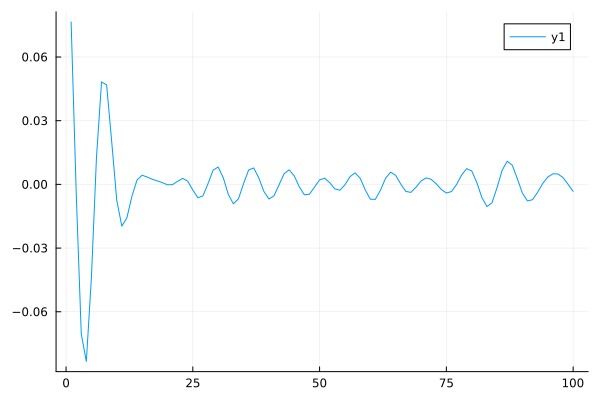

In [105]:
plot(xx)

In [37]:
# 1: (a+a^\dag)/2 
# 2: i(a-a^\dag)/2 
# 3: S_x 
# 4: S_y 
# 5: S_z
# 6: g(t)
# 7: t of last bang
Δ = 1.0 # MHz
ω = 1.0 # MHz
κ = 0.01
g_init = 0.5

g_c = 1/2*sqrt(ω*(Δ^2 + κ^2)/Δ)

# if g > g_c
#     inital = [g*Δ/(Δ^2 + κ^2), 0, 1.0, 0, (Δ^2 + κ^2)/Δ*ω/g^2]
# else
#     inital = [0., 0., 1.0, 0., 0.]
# end
angle = 2*pi*rand(Float64, 2)
angle[1] = angle[1] % pi
x = rand(Float64)
inital = [x,0., sin(angle[1]), cos(angle[1])*cos(angle[2]), cos(angle[1])*sin(angle[2]), g_init, 0.0]

t_last_bang = 0.0
cool_down_t = 10.0
max_x = 0.1

function dicke(du, u, p, t)
    if abs(u[1]) < max_x && t - u[7] > cool_down_t
        u[7] = t
        u[6] = -u[6]
    end

    du[1] = Δ*u[2]-κ*u[1]
    du[2] = -Δ*u[1]-κ*u[2]+g*u[3]
    du[3] = -ω*u[4]
    du[4] = ω*u[3]+g*u[1]*u[5]
    du[5] = -g*u[1]*u[4]
    du[6] = 0.0
    du[7] = 0.0
end

function σ_dicke(du, u, p, t)
    du[1] = -sqrt(κ/2)
    du[2] = -sqrt(κ/2)
    du[3] = 0.
    du[4] = 0.
    du[5] = 0.
    du[6] = 0.0
    du[7] = 0.0
end

prob_sde_lorenz = SDEProblem(dicke, σ_dicke, inital, (0.0, 4000.0))
sol = solve(prob_sde_lorenz, SKenCarp())

retcode: Success
Interpolation: 1st order linear
t: 5862-element Vector{Float64}:
    0.0
    0.005890140733836633
    0.012516549059402846
    0.019971258425664835
    0.028357806462709575
    0.03779267300438491
    0.04840689786376966
    0.060347900830577506
    0.07378152916823633
    0.08889436104810251
    0.10589629691295196
    0.1250234747609076
    0.1465415498398577
    ⋮
 3992.99596513313
 3993.8114408052097
 3994.4179853626943
 3995.100347989864
 3995.728387480952
 3996.434931908426
 3996.9896612429325
 3997.613731744252
 3998.2742169251865
 3999.0172627537377
 3999.683030669504
 4000.0
u: 5862-element Vector{Vector{Float64}}:
 [0.8635968503332846, 0.0, 0.8790675997750091, 0.27644444674129365, 0.3883537342316981, 0.5, 0.0]
 [0.8564440994099783, 0.0035883378262419243, 0.8774130529419665, 0.2855330462654868, 0.3855114929900105, 0.5, 0.0]
 [0.8472398627592413, 0.008087324986504439, 0.8754941444154994, 0.29566793525800633, 0.3822200086154904, 0.5, 0.0]
 [0.8459691525137187, 0

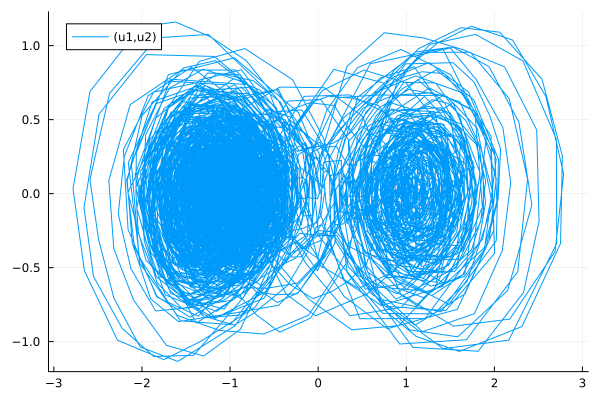

In [38]:
plot(sol, idxs = (1, 2))

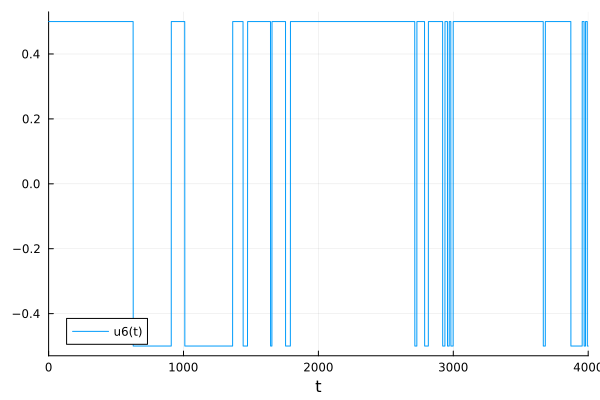

In [39]:
plot(sol, idxs = (6))